# Project 3 Detecting Sarcopenia
## Francis Yang 1/2/2023
Background:
Age-related loss of skeletal muscle mass and function, defined as sarcopenia, is significantly
related to adverse health outcomes e.g. increased risk of falls and fractures, physical frailty,
mobility limitation, and even premature mortality.
1. Besides, aging, smoking, physical inactivity, malnutrition and chronic comorbid diseases such as hypertension (HT), diabetes mellitus (DM),coronary artery disease (CAD), hyperlipidemia and obesity also have deteriorative effects on muscle mass and function.
2. Prevention of sarcopenia-related morbidity and mortality, among aging people in particular, depends on early detection and treatment, more importantly on unraveling the relationships between muscle loss, decline in muscle function and physical
performance and the aforementioned potential predictor

**Objective: PREDICT IF A USER WILL BE DEVELOPING SARCOPENIA.**

1. **Preprocessing**
    Read the data and print the data information, the shape of the data and explore it. You may need to create new variables such as Education level, Smoking, Gender, Exercise, etc.
2. **Modeling**
    Implement Logistic Regression, Random Forest, and Gradient Boosting on this dataset.
    You might plan to develop two separate models for men and women, as gender plays a significant role in Sarcopenia.
    
You will develop three models:

    * Model 1: Determine the probability that the patient has Sarcopenia based on variables available when the patient is home, such as age, weight, height, exercise, Hypertension, DM, Education, Smoking.. Values for these variables can be obtained without the patient reporting physically to a clinic. At the end of Model 1, diagnose patients with very high probability of developing Sarc as positive and very low probability of Sarc as negative. The remaining patients need further testing, so send them to the next model.
    
    * Model 2: Predict the Sarcopenia probability including CST and GSP. To measure CST, “Chair Stand Test”, a physician times a patient when she sits and stands up on a chair five times. To measure GSP, “Gait speed test”, a physician times a patient when she walks a certain distance. We are provided with these two features in the dataset. In the second model, in addition to the variables we used in the first model, we will include CST and GSP.

    * Model 3: Predict the Sarcopenia including ‘GRS’, Grip Strength Test. A physician measures the grip strength of a patient using a gyro hand grip. We will include GRS into our model with all the variables from Model 2. 
So, in sum, we start with a patient pool, we first eliminate the ones that we are almost certain whether they have Sarcopenia or not. Next, the remaining patients go through Model 2 and we again eliminate the patients that we are almost certain whether they
have Sarcopenia or not. We will repeat the same procedure for Model 3. The remaining
patients after Model 3 will go through ultrasound process to measure their muscle
thickness, which will increase the certainty for diagnosing whether they have
Sarcopenia. Our goal is, making the diagnosis as much as possible and reduce number of
patients going through extra tests.
In your deliverable, report precision, recall, f1, and auc scores. Report feature with a
bar graph.
### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
data = pd.read_csv("datasets/DataSampled.csv")

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MMSE                   812 non-null    float64
 1   Age                    1303 non-null   int64  
 2   Weight                 1302 non-null   float64
 3   Height                 1301 non-null   float64
 4   Waist                  1297 non-null   float64
 5   Hip                    1296 non-null   float64
 6   Smoking                1302 non-null   float64
 7   Smoking (packet/year)  1301 non-null   object 
 8   Alcohol                1303 non-null   object 
 9   DM                     1303 non-null   int64  
 10  DM duration            1289 non-null   float64
 11  Insulin                1297 non-null   float64
 12  DM drug                379 non-null    object 
 13  Hyperlipidemia         1301 non-null   float64
 14  Dyslipidemia duration  1287 non-null   float64
 15  Dysl

Column names and missing values shown above. <br>
There are some columns that are intended to be boolean and not int64. They are **Smoking**, **DM**, **Insulin**, **Hyperlipidemia**, **KAH**, **Hypothyroidism**, **KOAH**, **OP**, **HT**.
There are 2 more columns **LowCST** and **Low grip strength** that are boolean, but they seem to be predictors for the actural CST and Grip Strength columns.
#### Missing Data and dType correction

In [3]:
num_na = []
for col in list(data.columns):
    num_na.append(data[col].isna().sum())
col_na = dict(zip(data.columns,num_na))
col_na = pd.Series(col_na)
print("length",len(col_na[col_na>0]))
col_na[col_na>0]

length 32


MMSE                      491
Weight                      1
Height                      2
Waist                       6
Hip                         7
Smoking                     1
Smoking (packet/year)       2
DM duration                14
Insulin                     6
DM drug                   924
Hyperlipidemia              2
Dyslipidemia duration      16
Dyslipidemia drugs       1072
KAH                        42
KAH duration               54
Hypothyroidism             32
ASTIM                     123
KOAH                       78
OP                        948
Other(s)                 1018
Anti-HT drug type         553
HT duration                42
Education                  20
Occupation                 64
Working Status             80
Exercise                   20
LowCST                    190
Gait speed                  3
Low grip strength         137
SARCOPENIA                  1
STAR                        8
BMI                         2
dtype: int64

In [4]:
data['Gender'] = data['Gender'].str.upper()
data['Gender'] = data['Gender'].str.strip()
data['Gender'] = data['Gender'].astype("category")
data['Gender'].value_counts()

F    924
M    379
Name: Gender, dtype: int64

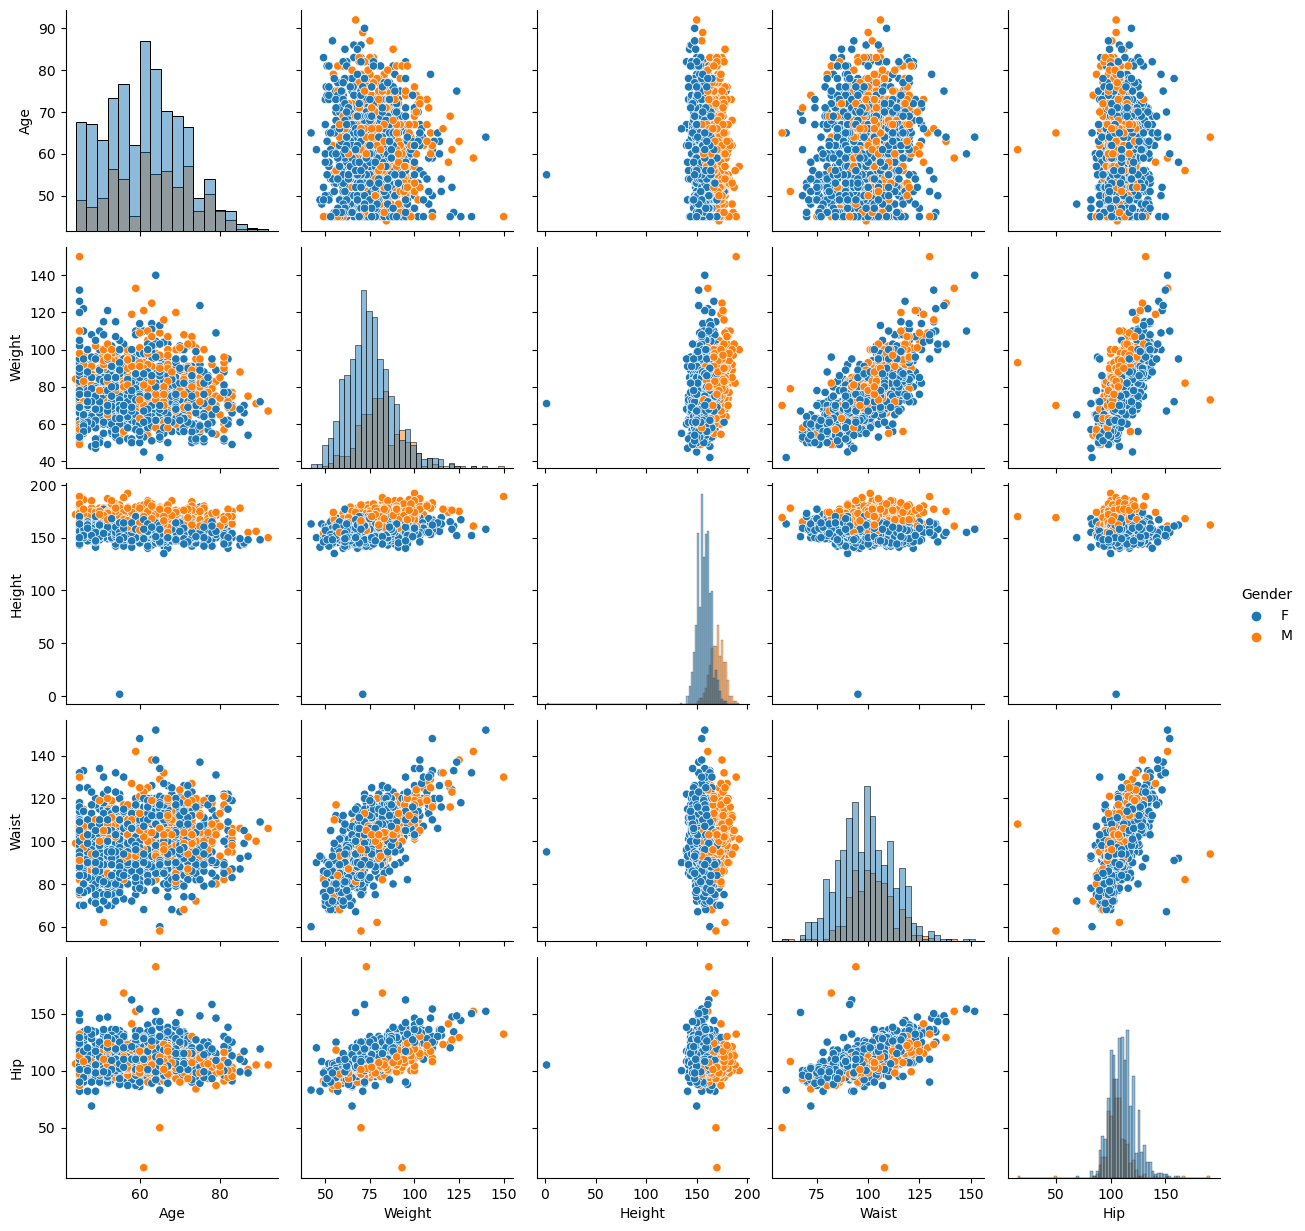

In [5]:
body = data.loc[:,('Age','Weight','Height','Waist','Hip','Gender')]
sns.pairplot(body, hue='Gender', diag_kind="hist")

It is possible to impute the missing values for Weight, Height, etc., based on a linear model, but I'm not going to do that because there are few records missing in each column.

In [6]:
# mean imputation
data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
data['Height'] = data['Height'].fillna(data['Height'].mean())
data['Waist'] = data['Waist'].fillna(data['Waist'].mean())
data['Hip'] = data['Hip'].fillna(data['Hip'].mean())

In [7]:
data['Smoking'] = data['Smoking'].fillna("0")

In [8]:
import re


def only_digits(value):
    if re.search('\d{1,3}(?=\/)|\d{1,3}(?=[A-Z])|\d{1,3}(?=\s\()', value):
        obj = re.search('\d{1,3}(?=\/)|\d{1,3}(?=[A-Z])|\d{1,3}(?=\s\()',
                        value)
        return (obj.group())

    elif re.search('(?<=:\s)\d{1,3}$', value):
        obj = re.search('(?<=:\s)\d{1,3}$', value)
        return (obj.group())

    elif re.search('\d{1,3}(?=\syears)', value):
        obj = re.search('\d{1,3}(?=\syears)', value)
        return (obj.group())

    else:
        return (value)


# only apply function on the following query
x = data.loc[(data['Smoking (packet/year)'].str.isnumeric() == False)].index
data.iloc[x, 7] = data.iloc[x, 7].apply(only_digits)

# remaining false querys are all floats
# change column dtype to float64
data['Smoking (packet/year)'] = data['Smoking (packet/year)'].astype(float)

In [9]:
data['Alcohol'] = data['Alcohol'].str.lower()
data['Alcohol'].value_counts()

0          1127
social      160
regular      16
Name: Alcohol, dtype: int64

In [10]:
data['DM'] = data['DM'].astype(bool)
data['Insulin'] = data['Insulin'].astype(bool)

data['LowCST'] = data['LowCST'].astype('category')
data['Low grip strength'] = data['Low grip strength'].astype('category')

In [11]:
data['DM drug'] = data['DM drug'].str.title()
data['DM drug'] = data['DM drug'].str.strip()
print(data['DM drug'].value_counts())

Metformin                                                     150
Metformin, Gliclazide                                          11
Gliclazide                                                     10
Sitagliptin, Metformin                                         10
Insulin                                                         8
                                                             ... 
Empagliflozin,Metformin                                         1
Gliclazide 60, Akarboz 150, Stagliptin 100, Pioglitazon 30      1
Metformin,Gliklazıd,Insulin                                     1
Sitagliptin,Metformin,Gliclazidee                               1
Pioglitazon, Empagliflozin                                      1
Name: DM drug, Length: 160, dtype: int64


In [12]:
#data['num DM drug'] = len(data['DM drug'].str.split())
data['DM drug'] = data['DM drug'].replace('+', ',')
data['DM drug'] = data['DM drug'].replace('/', ',')


def count_drugs(value):
    if type(value) == float:
        # captures Nan values
        return 0

    if value:
        drugs = value.split(',')
        return len(drugs)
    return 0


# create new column
data['num DM drug'] = data['DM drug'].apply(count_drugs)
data['num DM drug'].value_counts()

0    924
1    210
2    100
3     55
4     13
5      1
Name: num DM drug, dtype: int64

In [13]:
data['Dyslipidemia drugs'] = data['Dyslipidemia drugs'].str.title()
data['num Dyslipidemia drugs'] = data['Dyslipidemia drugs'].apply(count_drugs)
data['num Dyslipidemia drugs'].value_counts()

0    1072
1     220
2      11
Name: num Dyslipidemia drugs, dtype: int64

In [14]:
data['Education'] = data['Education'].str.lower()
data['Education'] = data['Education'].fillna('none')
data['Education'].value_counts()

primary school      515
high school         234
illiterate          187
university          183
secondary school    156
none                 23
housewife             4
worker                1
Name: Education, dtype: int64

In [15]:
data['Working Status'] = data['Working Status'].str.lower()
data['Working Status'] = data['Working Status'].fillna('none')
data['Working Status'].value_counts()

retired                     721
unemployed                  180
full-time/part-time work    112
working                      98
none                         82
housewife                    41
full-time work               29
part-time work               23
not working                  12
abstinence                    5
Name: Working Status, dtype: int64

In [16]:
data['Exercise'] = data['Exercise'].fillna("0")

In [17]:
# check again for nulls
num_na = []
for col in list(data.columns):
    num_na.append(data[col].isna().sum())
col_na = dict(zip(data.columns,num_na))
col_na = pd.Series(col_na)
print("length",len(col_na[col_na>0]))
col_na[col_na>0]

length 23


MMSE                      491
Smoking (packet/year)       2
DM duration                14
DM drug                   924
Hyperlipidemia              2
Dyslipidemia duration      16
Dyslipidemia drugs       1072
KAH                        42
KAH duration               54
Hypothyroidism             32
ASTIM                     123
KOAH                       78
OP                        948
Other(s)                 1018
Anti-HT drug type         553
HT duration                42
Occupation                 64
LowCST                    190
Gait speed                  3
Low grip strength         137
SARCOPENIA                  1
STAR                        8
BMI                         2
dtype: int64

In [37]:
data['Alcohol'].value_counts()

0          1127
social      160
regular      16
Name: Alcohol, dtype: int64

High imbalance on **Gender**. Will split in model training.
### Data Visualizations

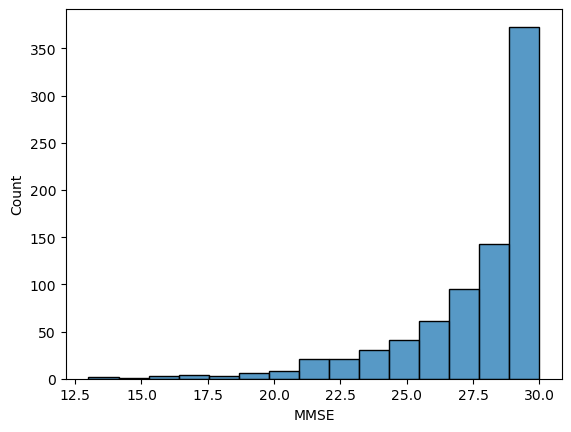

In [18]:
sns.histplot(data=data,x='MMSE', bins=15);

MMSE stands for Mini-Mental State Examination. Maximum points is 30. According to Wikipedia:
```
Any score of 24 or more (out of 30) indicates a normal cognition. Below this, scores can indicate severe (≤9 points), moderate (10–18 points) or mild (19–23 points) cognitive impairment. The raw score may also need to be corrected for educational attainment and age.
```

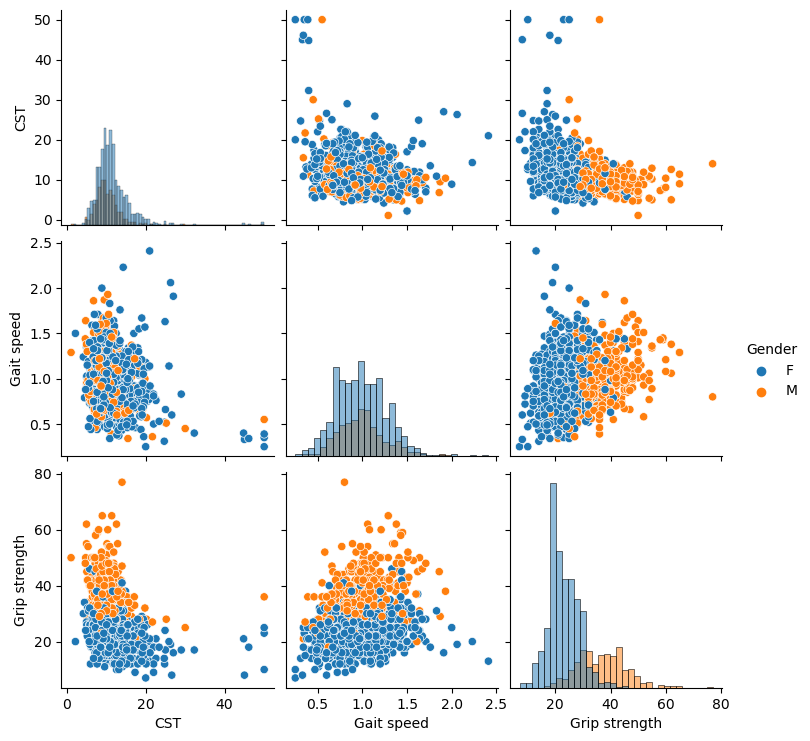

In [19]:
tests = data.loc[:,('LowCST','CST','Gait speed','Low grip strength','Grip strength','Gender')]
sns.pairplot(tests, hue='Gender', diag_kind="hist")

#### Variables where imputing makes sense
MMSE   float64
Weight float64
Height float64
Waist  float64
Hip    float64
Smoking (packet/year) float64 
 10  DM duration            1289 non-null   float64
 11  Insulin                1297 non-null   float64
 12  DM drug                379 non-null    object 
 13  Hyperlipidemia         1301 non-null   float64
 14  Dyslipidemia duration  1287 non-null   float64
 15  Dyslipidemia drugs     231 non-null    object 
 16  KAH                    1261 non-null   float64
 17  KAH duration           1249 non-null   float64
 18  Hypothyroidism         1271 non-null   float64
 19  ASTIM                  1180 non-null   float64
 20  KOAH                   1225 non-null   float64
 21  OP                     355 non-null    float64
 22  Other(s)               285 non-null    object 
 23  HT                     1303 non-null   int64  
 24  Anti-HT drug type      750 non-null    object 
 25  HT duration            1261 non-null   float64
 26  Education              1283 non-null   object 
 27  Occupation             1239 non-null   object 
 28  Working Status         1223 non-null   object 
 29  Exercise               1283 non-null   object 
 30  LowCST                 1113 non-null   float64
 31  CST                    1303 non-null   float64
 32  Gait speed             1300 non-null   float64
 33  Low grip strength      1166 non-null   float64
 34  Grip strength          1303 non-null   int64  
 35  SARCOPENIA             1302 non-null   float64
 36  STAR                   1295 non-null   float64
 37  BMI                    1301 non-null   float64
 38  Gender                 1303 non-null   object 
 #### Data Split on Gender

In [20]:
male = data.loc[data['Gender'] == 'M']
female = data.loc[data['Gender'] == 'F']

### Model 1
*Estimators*: age, weight, height, hip, exercise, Hypertension (HT), DM, Education, Smoking, Alcohol <br>
*Models*: Logistic Regression, Random Forest, and Gradient Boosting <br>
Transforms:<br>
> Column: Exercise, Education, Alcohol

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


Xmale = male.loc[:, ('Age', 'Weight', 'Height', 'Hip', 'HT', 'Smoking',
                     'Exercise', 'Alcohol')].values
Xfemale = female.loc[:, ('Age', 'Weight', 'Height', 'Hip', 'HT', 'Smoking',
                         'Exercise', 'Alcohol')].values
Ymale = male['SARCOPENIA'].values
Yfemale = female['SARCOPENIA'].values

l_X_1 = LabelEncoder()
Xmale[:, 6] = l_X_1.fit_transform(Xmale[:, 6])  # Exercise
Xfemale[:, 6] = l_X_1.fit_transform(Xfemale[:, 6])

l_X_2 = LabelEncoder()
Xmale[:, 7] = l_X_2.fit_transform(Xmale[:, 7])  # Alcohol
Xfemale[:, 7] = l_X_2.fit_transform(Xfemale[:, 7])

l_y = LabelEncoder()
Ymale = l_y.fit_transform(Ymale)
Yfemale = l_y.fit_transform(Yfemale)

X_train, X_test, y_train, y_test = train_test_split(Xmale, Ymale, random_state=6)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(Xfemale, Yfemale, random_state=6)

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('scaler', StandardScaler()),
                ('model', LogisticRegression(C=1000, max_iter=50000))
                ])
pipe.fit(X_train, y_train)
accuracy = pipe.score(X_test, y_test)*100
print(f'Male Logistic Regression Accuracy: {accuracy:.2f}%')

pipe.fit(X_train_f, y_train_f)
accuracy = pipe.score(X_test_f, y_test_f)*100
print(f'Female Logistic Regression Accuracy: {accuracy:.2f}%')

Male Logistic Regression Accuracy: 82.11%
Female Logistic Regression Accuracy: 81.39%
